# Named Entity Recognition
Bo Tang, Lei Zhang

## Data Loading

In [0]:
# Code to download file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id = '1bRJfOMg3mF7nkwtYBk1zNEt_rPbaX3gY'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('train.csv')

id = '1qKJMnnb5xKPtl6_qzqPXyu-yvmcXY2g4'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('test.csv')

id = '1wgCCkjZpXEZ-Z2xarj0LTopJ38AR3Ylu'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('val.csv')

import pandas as pd

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_val = pd.read_csv('val.csv')

print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

(3000, 2)
(3684, 2)
(700, 2)


## Data Preprocessing

### Spliting

In [0]:
print(df_train[:10])

                                            Sentence                                                NER
0                                         -docstart-                                                  O
1   eu rejects german call to boycott british lamb .                    I-ORG O I-MISC O O O I-MISC O O
2                                    peter blackburn                                        I-PER I-PER
3                                brussels 1996-08-22                                            I-LOC O
4  the european commission said on thursday it di...  O I-ORG I-ORG O O O O O O I-MISC O O O O O I-M...
5  germany 's representative to the european unio...  I-LOC O O O O I-ORG I-ORG O O O I-PER I-PER O ...
6  " we do n't support any such recommendation be...  O O O O O O O O O O O O O O O O O O O O I-ORG ...
7  he said further scientific study was required ...  O O O O O O O O O O O O O O O O O O O O O O I-...
8  he said a proposal last month by eu farm commi...  O O O O O 

In [0]:
import numpy as np

def data_prep(data):
  lines = [line.strip().split(' ') for line in data.iloc[:,0].tolist()]
  tags = [tag.strip().split(' ') for tag in data.iloc[:,1].tolist()]

  for i in range(len(lines)):
    if len(lines[i]) != len(tags[i]):
      print('Data Err!')
      return

  return lines, tags

lines_train, tags_train = data_prep(df_train)
lines_test = [line.strip().split(' ') for line in df_test.iloc[:,0].tolist()]
lines_val, tags_val = data_prep(df_val)
print(len(lines_train), len(tags_train))
print(len(lines_val), len(tags_val))
print(len(lines_test))

3000 3000
700 700
3684


## Input Embedding

### Word2Vec

In [0]:
sentences = lines_train + lines_val + lines_test

word_to_ix = {}
for sentence in sentences:
  for word in sentence:
    if word not in word_to_ix:
      word_to_ix[word] = len(word_to_ix)

word_list = list(word_to_ix.keys())

START_TAG = "<START>"
STOP_TAG = "<STOP>"

tag_to_ix = {START_TAG:0, STOP_TAG:1}
for tags in tags_train + tags_val:
  for tag in tags:
    if tag not in tag_to_ix:
      tag_to_ix[tag] = len(tag_to_ix)


print(len(word_list))
print(sentences[:10])

13972
[['-docstart-'], ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.'], ['peter', 'blackburn'], ['brussels', '1996-08-22'], ['the', 'european', 'commission', 'said', 'on', 'thursday', 'it', 'disagreed', 'with', 'german', 'advice', 'to', 'consumers', 'to', 'shun', 'british', 'lamb', 'until', 'scientists', 'determine', 'whether', 'mad', 'cow', 'disease', 'can', 'be', 'transmitted', 'to', 'sheep', '.'], ['germany', "'s", 'representative', 'to', 'the', 'european', 'union', "'s", 'veterinary', 'committee', 'werner', 'zwingmann', 'said', 'on', 'wednesday', 'consumers', 'should', 'buy', 'sheepmeat', 'from', 'countries', 'other', 'than', 'britain', 'until', 'the', 'scientific', 'advice', 'was', 'clearer', '.'], ['"', 'we', 'do', "n't", 'support', 'any', 'such', 'recommendation', 'because', 'we', 'do', "n't", 'see', 'any', 'grounds', 'for', 'it', ',', '"', 'the', 'commission', "'s", 'chief', 'spokesman', 'nikolaus', 'van', 'der', 'pas', 'told', 'a', 'news', 'briefin

In [0]:
import gensim.downloader as api
word_emb_model = api.load("glove-twitter-50") 

EMBEDDING_DIM = 50

embedding_matrix = []
for word in word_list:
  try:
    embedding_matrix.append(word_emb_model.wv[word])
  except:
    embedding_matrix.append([0]*EMBEDDING_DIM)

embedding_matrix = np.array(embedding_matrix)
print(embedding_matrix.shape)

[=================================================-] 98.8% 197.1/199.5MB downloaded(13972, 50)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if __name__ == '__main__':


In [0]:
def to_index(data, to_ix):
    input_index_list = []
    for sent in data:
        input_index_list.append([to_ix[w] for w in sent])
    return input_index_list

train_input_index =  to_index(lines_train,word_to_ix)
train_output_index = to_index(tags_train,tag_to_ix)
val_input_index = to_index(lines_val,word_to_ix)
val_output_index = to_index(tags_val,tag_to_ix)
test_input_index = to_index(lines_test,word_to_ix)

### POS Tags

In [0]:
import nltk
nltk.download('averaged_perceptron_tagger')

from nltk import word_tokenize
from sklearn.preprocessing import MinMaxScaler

#get pos-tag and sentences
pos_tag_sentences = []
for word in sentences:
   pos_tag_sentences.append(nltk.pos_tag(word))

#get pos-tag
sentence_tags=[]
for tagged in pos_tag_sentences:
  tmp= []
  for i in tagged:
    tmp.append(i[1])
  sentence_tags.append(tmp)

#create sentence tag dictionary
sentence_tags_set =list(set([i for item in sentence_tags for i in item]))
tag2index = {w : i+2 for i,w in enumerate(sentence_tags_set)}
# tag2index['0'] = 0


#get all sentence tags
final_tagged = []
for tags in sentence_tags:
  tmp= []
  for i in tags:
    tmp.append(tag2index[i])
  final_tagged.append(tmp)
#padding
tag_pad = []
for tag in final_tagged:
  tag_pad.append([0]*(124-(len(tag)))+tag)
tag_pad = np.array(tag_pad , dtype='float64')

#MinMaxScaler
scaler_tag_range = MinMaxScaler(feature_range=(0,1))
scaled_tag = scaler_tag_range.fit_transform(tag_pad)
# print(scaled_tag[5])
#get final get minmaxScaler in each sentence
mv_zero_scaler  = scaled_tag.tolist()
tagger_train = []
tagger_val = []
tagger_test =[]

for i in range(len(mv_zero_scaler)):
  tmp =[]
  for j in mv_zero_scaler[i]:
    if j != 0:
      tmp.append([j])
  if len(tmp)< len(final_tagged[i]):
    tmp.append([0.0]*(len(final_tagged[i])-(len(tmp))))
  if i <3000:
    tagger_train.append(tmp)
  if 3000<= i <3700:
    tagger_val.append(tmp)
  if i>=3700:
    tagger_test.append(tmp)

# tagger_train
#tagger_val
#tagger_test


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


### TFIDF

In [0]:
from collections import Counter
import math
def get_tf_and_idf(tokenized_docs):
    result =[]
    N = len(tokenized_docs) 
    # Calaulating document frequency for each word
    DF = {}
    for tokenized_doc in tokenized_docs:
        # get each unique word in the doc - we need to know whether the word is appeared in the document
        for term in np.unique(tokenized_doc):
            try:
                DF[term] +=1
            except:
                DF[term] =1
    # Calculating tf, tf-idf
    tf_idf_dict = {}
    tf_dict = {}
    doc_id = 0
    for tokenized_doc in tokenized_docs:
        # initialise counter for the doc
        counter = Counter(tokenized_doc)
        # calculate total number of words in the doc
        total_num_words = len(tokenized_doc)  
        # get each unique word in the doc
        for term in np.unique(tokenized_doc):
            #calculate Term Frequency 
            tf = counter[term]/total_num_words
            tf_dict[doc_id, term] = tf         
            #calculate Document Frequency
            df = DF[term]
            # calculate Inverse Document Frequency
            idf = math.log(N/(df+1))+1
            # calculate TF-IDF
            tf_idf_dict[term] = tf*idf
        doc_id += 1
    for i in tokenized_docs:
      tmp=[]
      for j in i:
        tmp.append([tf_idf_dict[j]])
      result.append(tmp)
    return result

tf_idf_train =get_tf_and_idf(lines_train)
tf_idf_val =get_tf_and_idf(lines_val)
tf_idf_test=get_tf_and_idf(lines_test)

## Named Entity Recongnition

### Model Design

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F
import torch.autograd as autograd
import torch.optim as optim
import numpy as np

torch.manual_seed(1)

def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

class BiLSTM_Attn(nn.Module):
    ATTN_TYPE_DOT = "Dot"
    ATTN_TYPE_CONCAT = "CONCAT"

    def __init__(self, vocab_size, embedding_dim, tag_to_ix, hidden_dim, num_layers, attn_type):
        super(BiLSTM_Attn, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim    = hidden_dim
        self.vocab_size = vocab_size
        self.num_layers    = num_layers
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)
        self.attn_type = attn_type

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.word_embeds.weight.data.copy_(torch.from_numpy(embedding_matrix))

        self.lstm = nn.LSTM(
                    embedding_dim+2, hidden_dim,
                    num_layers = self.num_layers,
                    bidirectional=True)

        self.hidden2tag = nn.Linear(hidden_dim * 2, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.randn(self.num_layers * 2, 1, self.hidden_dim).to(device),
                torch.randn(self.num_layers * 2, 1, self.hidden_dim).to(device))
    
    def make_comb_feats(self, sentence, tfidfs, pos_tags):
        embeds = self.word_embeds(sentence).view(len(sentence), -1)
        #print(embeds.shape, tfidfs.shape, pos_tags.shape)
        embeds = torch.cat((embeds, tfidfs, pos_tags), 1)

        return embeds

    def get_lstm_feats(self, embeds):
        self.hidden = self.init_hidden()
        embeds = embeds.view(len(embeds), 1, -1)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)

        return lstm_out
        
    def attention(self, lstm_output):
        lstm_output_t = lstm_output[:,:,-2*self.hidden_dim:].transpose(1, 2)
        attn_weight = torch.cat((self.hidden[0][-2].view(1,self.hidden_dim), self.hidden[0][-1].view(1,self.hidden_dim)), 1)
        #print(lstm_output.shape, attn_weight.shape)

        if self.attn_type == self.ATTN_TYPE_CONCAT:
            M = torch.tanh(lstm_output_t)
            a = F.softmax(torch.matmul(M, attn_weight), 2)
            #print(a.shape, lstm_output.shape)
            # print(lstm_output.shape, a.shape)
            attn_output = torch.bmm(lstm_output, a)

        elif self.attn_type == self.ATTN_TYPE_DOT:
            H = F.softmax(torch.matmul(lstm_output_t, attn_weight), -1)
            # print(lstm_output.shape, H.shape)
            attn_output = torch.bmm(lstm_output, H)

        return attn_output
    
    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1).to(device)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).to(device), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, tfidfs, pos_tags, tags):
        embeds = self.make_comb_feats(sentence, tfidfs, pos_tags)
        lstm_output = self.get_lstm_feats(embeds)
        attn_output = self.attention(lstm_output)
        attn_feats = self.hidden2tag(attn_output).view(len(sentence), self.tagset_size)
        forward_score = self._forward_alg(attn_feats)
        gold_score = self._score_sentence(attn_feats, tags)
        return forward_score - gold_score

    def forward(self, sentence, tfidfs, pos_tags):
        embeds = self.make_comb_feats(sentence, tfidfs, pos_tags)
        lstm_output = self.get_lstm_feats(embeds)
        attn_output = self.attention(lstm_output)
        attn_feats = self.hidden2tag(attn_output).view(len(sentence), self.tagset_size)
        score, tag_seq = self._viterbi_decode(attn_feats)

        return tag_seq

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HIDDEN_DIM = 100

### Accuracy Calculation

In [0]:
import numpy as np
def cal_acc(model, input_index, input_tfidfs, input_pos_tags, output_index):
    acc = 0
    total = 0
    ground_truth = []
    predicted = []
    for i, idxs in enumerate(input_index):
        tags_index = output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        tfidfs = torch.tensor(input_tfidfs[i], dtype=torch.float).to(device)
        pos_tags = torch.tensor(input_pos_tags[i], dtype=torch.float).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        pred = model.forward(sentence_in, tfidfs, pos_tags)
        # print(pred)
        # print(tags_index)
        for j in range(len(pred)):
            if pred[j] == tags_index[j]:
                acc+=1
        total += len(pred)
    
    accuracy = acc / total
    return accuracy

### Hyperparameters Evaluation
Different layer design and attention methods

In [0]:
import datetime

configs = [
    {
        'nlayer':1,
        'attn_type':'Dot',
        'train_losses':[],
        'val_losses':[],
        'train_acc':[],
        'val_acc':[]
    },
    {
        'nlayer':1,
        'attn_type':'CONCAT',
        'train_losses':[],
        'val_losses':[],
        'train_acc':[],
        'val_acc':[]
    },
    {
        'nlayer':2,
        'attn_type':'Dot',
        'train_losses':[],
        'val_losses':[],
        'train_acc':[],
        'val_acc':[]
    },
    {
        'nlayer':2,
        'attn_type':'CONCAT',
        'train_losses':[],
        'val_losses':[],
        'train_acc':[],
        'val_acc':[]
    }

]


for config in configs:

  model = BiLSTM_Attn(len(word_to_ix), EMBEDDING_DIM, tag_to_ix, HIDDEN_DIM, config['nlayer'], config['attn_type']).to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)
  # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.95)
  

  for epoch in range(10):  
      time1 = datetime.datetime.now()
      train_loss = 0

      model.train()
      for i, idxs in enumerate(train_input_index):
          # Step 1. Remember that Pytorch accumulates gradients.
          # We need to clear them out before each instance
          model.zero_grad()

          # Step 2. Get our inputs ready for the network, that is,
          # turn them into Tensors of word indices.
          sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
          tfidfs = torch.tensor(tf_idf_train[i], dtype=torch.float).to(device)
          pos_tags = torch.tensor(tagger_train[i], dtype=torch.float).to(device)
          targets = torch.tensor(train_output_index[i], dtype=torch.long).to(device)

          # Step 3. Run our forward pass.
          loss = model.neg_log_likelihood(sentence_in, tfidfs, pos_tags, targets)

          # Step 4. Compute the loss, gradients, and update the parameters by
          # calling optimizer.step()
          loss.backward()
          optimizer.step()
          # scheduler.step()


          train_loss+=loss.item()
      config['train_losses'].append(train_loss)

      model.eval()
      train_acc = cal_acc(model, train_input_index, tf_idf_train, tagger_train, train_output_index)
      val_acc = cal_acc(model, val_input_index, tf_idf_val, tagger_val, val_output_index)
      config['train_acc'].append(train_acc)
      config['val_acc'].append(val_acc)


      val_loss = 0
      for i, idxs in enumerate(val_input_index):
          tags_index = val_output_index[i]
          sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
          tfidfs = torch.tensor(tf_idf_val[i], dtype=torch.float).to(device)
          pos_tags = torch.tensor(tagger_val[i], dtype=torch.float).to(device)
          targets = torch.tensor(tags_index, dtype=torch.long).to(device)
          loss = model.neg_log_likelihood(sentence_in, tfidfs, pos_tags, targets)
          val_loss+=loss.item()

      config['val_losses'].append(val_loss)
      time2 = datetime.datetime.now()

      print("Epoch:%d, Training loss: %.2f, train acc: %.4f, val loss: %.2f, val acc: %.4f, time: %.2fs" %(epoch+1, train_loss,train_acc, val_loss, val_acc, (time2-time1).total_seconds()))


Epoch:1, Training loss: 15519.07, train acc: 0.8747, val loss: 2699.54, val acc: 0.8626, time: 192.25s
Epoch:2, Training loss: 10285.27, train acc: 0.8950, val loss: 2245.51, val acc: 0.8823, time: 187.28s
Epoch:3, Training loss: 8785.57, train acc: 0.9059, val loss: 2010.56, val acc: 0.8957, time: 184.84s
Epoch:4, Training loss: 7524.60, train acc: 0.9201, val loss: 1782.53, val acc: 0.9096, time: 184.97s
Epoch:5, Training loss: 6284.20, train acc: 0.9324, val loss: 1634.22, val acc: 0.9165, time: 184.95s
Epoch:6, Training loss: 5230.53, train acc: 0.9414, val loss: 1540.81, val acc: 0.9236, time: 184.03s
Epoch:7, Training loss: 4464.24, train acc: 0.9488, val loss: 1514.05, val acc: 0.9264, time: 183.17s
Epoch:8, Training loss: 3876.02, train acc: 0.9535, val loss: 1573.73, val acc: 0.9272, time: 183.00s
Epoch:9, Training loss: 3384.93, train acc: 0.9568, val loss: 1658.61, val acc: 0.9287, time: 182.02s
Epoch:10, Training loss: 2983.75, train acc: 0.9596, val loss: 1689.53, val acc:

Single Layered BiLSTM with different attention methods

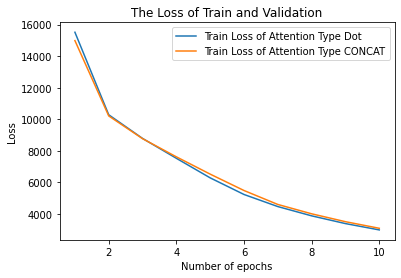

In [0]:
import matplotlib.pyplot as plt

plt.title('The Loss of Train and Validation')
plt.ylabel('Loss')
plt.xlabel('Number of epochs')


for config in configs[:2]:
  epochs = [i+1 for i in range(len(config['val_losses']))]
  train_losses = config['train_losses']
  val_losses = config['val_losses']
  # plt.plot(epochs,val_losses,label = 'Validation Loss of Attention Type {}'.format(config['attn_type']))
  plt.plot(epochs,train_losses,label = 'Train Loss of Attention Type {}'.format(config['attn_type']))

plt.legend()
plt.show()
# plt.subplots(figsize=(16,6))
# print(configs[0]['val_losses'])

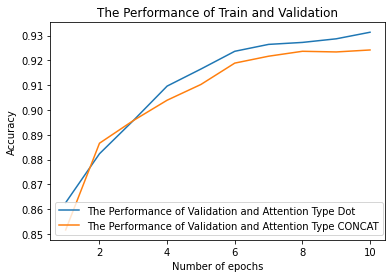

In [0]:
plt.title('The Performance of Train and Validation')
plt.ylabel('Accuracy')
plt.xlabel('Number of epochs')

for config in configs[:2]:
  epochs = [i+1 for i in range(len(config['train_acc']))]
  train_acc = config['train_acc']
  val_acc = config['val_acc']
  # plt.plot(epochs, train_acc,label = 'The Performance of Train Attention Type {}'.format(config['attn_type']))
  plt.plot(epochs, val_acc,label = 'The Performance of Validation and Attention Type {}'.format(config['attn_type']))


plt.legend()
plt.show()

Double Layered BiLSTM with different attention methods

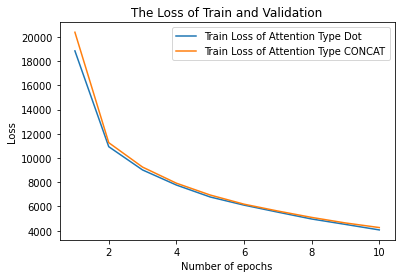

In [0]:
plt.title('The Loss of Train and Validation')
plt.ylabel('Loss')
plt.xlabel('Number of epochs')


for config in configs[2:]:
  epochs = [i+1 for i in range(len(config['val_losses']))]
  train_losses = config['train_losses']
  val_losses = config['val_losses']
  # plt.plot(epochs,val_losses,label = 'Validation Loss of Attention Type {}'.format(config['attn_type']))
  plt.plot(epochs,train_losses,label = 'Train Loss of Attention Type {}'.format(config['attn_type']))

plt.legend()
plt.show()

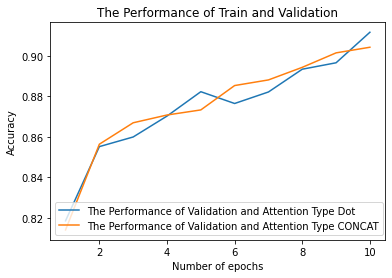

In [0]:
plt.title('The Performance of Train and Validation')
plt.ylabel('Accuracy')
plt.xlabel('Number of epochs')

for config in configs[2:]:
  epochs = [i+1 for i in range(len(config['train_acc']))]
  train_acc = config['train_acc']
  val_acc = config['val_acc']
  # plt.plot(epochs, train_acc,label = 'The Performance of Train Attention Type {}'.format(config['attn_type']))
  plt.plot(epochs, val_acc,label = 'The Performance of Validation and Attention Type {}'.format(config['attn_type']))


plt.legend()
plt.show()

### Model Training

In [0]:
import datetime

configs = [
    {
        'nlayer':1,
        'attn_type':'Dot',
        'train_losses':[],
        'train_acc':[],     
    }
]

for config in configs:

  model = BiLSTM_Attn(len(word_to_ix), EMBEDDING_DIM, tag_to_ix, HIDDEN_DIM, config['nlayer'], config['attn_type']).to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)
  
  for epoch in range(20):  
      time1 = datetime.datetime.now()
      train_loss = 0

      model.train()

      for i, idxs in enumerate(train_input_index):
          model.zero_grad()

          sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
          tfidfs = torch.tensor(tf_idf_train[i], dtype=torch.float).to(device)
          pos_tags = torch.tensor(tagger_train[i], dtype=torch.float).to(device)
          targets = torch.tensor(train_output_index[i], dtype=torch.long).to(device)

          loss = model.neg_log_likelihood(sentence_in, tfidfs, pos_tags, targets)

          loss.backward()
          optimizer.step()
          
          train_loss+=loss.item()
      config['train_losses'].append(train_loss)

      model.eval()
      val_acc = cal_acc(model, val_input_index, tf_idf_val, tagger_val, val_output_index)

      config['train_acc'].append(train_acc)

      time2 = datetime.datetime.now()

      print("Epoch:%d, Total loss: %.2f, Val acc: %.4f, time: %.2fs" %(epoch+1, train_loss, val_acc, (time2-time1).total_seconds()))

Epoch:1, Total loss: 16308.99, Val acc: 0.8624, time: 145.99s
Epoch:2, Total loss: 10658.80, Val acc: 0.8704, time: 144.56s
Epoch:3, Total loss: 9136.83, Val acc: 0.8781, time: 143.97s
Epoch:4, Total loss: 8012.14, Val acc: 0.8974, time: 144.70s
Epoch:5, Total loss: 6844.44, Val acc: 0.9125, time: 144.10s
Epoch:6, Total loss: 5731.96, Val acc: 0.9220, time: 144.39s
Epoch:7, Total loss: 4897.40, Val acc: 0.9263, time: 144.30s
Epoch:8, Total loss: 4240.94, Val acc: 0.9273, time: 146.84s
Epoch:9, Total loss: 3731.01, Val acc: 0.9288, time: 148.71s
Epoch:10, Total loss: 3315.41, Val acc: 0.9316, time: 145.33s
Epoch:11, Total loss: 2924.64, Val acc: 0.9336, time: 144.26s
Epoch:12, Total loss: 2588.24, Val acc: 0.9342, time: 144.12s
Epoch:13, Total loss: 2302.33, Val acc: 0.9353, time: 144.61s
Epoch:14, Total loss: 2077.02, Val acc: 0.9341, time: 145.15s
Epoch:15, Total loss: 1880.78, Val acc: 0.9355, time: 147.63s
Epoch:16, Total loss: 1683.06, Val acc: 0.9370, time: 151.09s
Epoch:17, Total

### Final Model Evaluation

In [0]:
from sklearn.metrics import classification_report
val_tags_pred=[]
total_tags=[] 
for line in val_output_index:
    total_tags += line

for i, idxs in enumerate(val_input_index):
    sentence_in=torch.tensor(idxs,dtype=torch.long).to(device)
    tfidfs=torch.tensor(tf_idf_val[i],dtype=torch.float).to(device)
    pos_tags=torch.tensor(tagger_val[i],dtype=torch.float).to(device)
    
    tags_index=model.forward(sentence_in,tfidfs,pos_tags)
    val_tags_pred+= tags_index

print(classification_report(total_tags,val_tags_pred))

              precision    recall  f1-score   support

           2       0.97      0.99      0.98      5790
           3       0.59      0.49      0.54       285
           4       0.61      0.65      0.63       187
           5       0.97      0.83      0.89       875
           6       0.80      0.89      0.84       419

    accuracy                           0.94      7556
   macro avg       0.79      0.77      0.78      7556
weighted avg       0.94      0.94      0.94      7556



### Submission Generating

In [0]:
from pandas.core.frame import DataFrame

model.eval()

ix_to_tag={tag_to_ix[tag]:tag for tag in tag_to_ix.keys()}
tags_test =[]
for i, idxs in enumerate(test_input_index):
    sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
    tfidfs=torch.tensor(tf_idf_test[i],dtype=torch.float).to(device)
    pos_tags=torch.tensor(tagger_test[i],dtype=torch.float).to(device)

    tags_index = model.forward(sentence_in,tfidfs,pos_tags)
    tags_test += [ix_to_tag[ix] for ix in tags_index]

id_list = [i for i in range(len(tags_test))]
dic_test = {
    "Id":id_list,
    "Predicted":tags_test
}

data_output = DataFrame(dic_test)
print(data_output)
data_output.to_csv('pred.csv',index =False)

          Id Predicted
0          0         O
1          1         O
2          2         O
3          3     I-LOC
4          4         O
...      ...       ...
46661  46661         O
46662  46662         O
46663  46663         O
46664  46664     I-PER
46665  46665         O

[46666 rows x 2 columns]


## Testing and Leaderboard

### Performance Comparison

Models|F1
---|---
Group 36|98.619
Baseline Model|93.022
Ours|92.302